In [1]:
from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.VAE_Generation import SingleStageVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

# Dataset

In [2]:
dataset = TrafficDataset.from_file(
    # "../../deep_traffic_generation/data/traffic_noga_tilFAF_train_enriched.pkl",
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

test = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_test.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    # scaler=MinMaxScaler(feature_range=(-1,1)),
    scaler=dataset.scaler,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

# Processing with dataset simplified

In [3]:
path = "../../deep_traffic_generation/lightning_logs/tcvae/version_17/"

t = SingleStageVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) #scaler of the first stage (the global scaler)

RuntimeError: Error(s) in loading state_dict for TCVAE:
	size mismatch for lsr.z_loc.0.weight: copying a param with shape torch.Size([64, 1344]) from checkpoint, the shape in current model is torch.Size([64, 2560]).
	size mismatch for lsr.z_log_var.0.weight: copying a param with shape torch.Size([64, 1344]) from checkpoint, the shape in current model is torch.Size([64, 2560]).
	size mismatch for lsr.pseudo_inputs_NN.2.weight: copying a param with shape torch.Size([420, 1000]) from checkpoint, the shape in current model is torch.Size([800, 1000]).
	size mismatch for lsr.pseudo_inputs_NN.2.bias: copying a param with shape torch.Size([420]) from checkpoint, the shape in current model is torch.Size([800]).
	size mismatch for decoder.decode_entry.weight: copying a param with shape torch.Size([1344, 64]) from checkpoint, the shape in current model is torch.Size([2560, 64]).
	size mismatch for decoder.decode_entry.bias: copying a param with shape torch.Size([1344]) from checkpoint, the shape in current model is torch.Size([2560]).

In [43]:
t = g.sample(200, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)
t

count
flight_id       
TRAJ_0       105
TRAJ_42      105
TRAJ_33      105
TRAJ_34      105
TRAJ_35      105
TRAJ_36      105
TRAJ_37      105
TRAJ_38      105
TRAJ_39      105
TRAJ_4       105

In [44]:
def reverse_padding(f, col = "altitude", threshold = 1000):
    mask = f.data[col] > threshold
    f.data = f.data[mask]
    return f

res = t.iterate_lazy().pipe(reverse_padding).eval(desc='reverse padding', max_workers=100)

reverse padding:   0%|          | 0/200 [00:00<?, ?it/s]

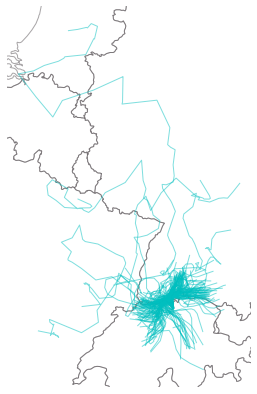

In [45]:
from traffic.drawing import countries
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    res.plot(ax, alpha=0.5, color="c")

# Latent Space

In [3]:
path = "../../deep_traffic_generation/lightning_logs/tcvae/version_25/"

t = SingleStageVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) #scaler of the first stage (the global scaler)

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#latent spaces of the single stage VAE, and N generated points within (the last N rows of the array)
#plot latent representation of the dataset used to initialized the SingleStageVAE object
n_gen = 2000
Z = t.latent_space(n_gen)

Z_embedded1 = TSNE(n_components=2).fit_transform(Z)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded2 = pca.transform(Z)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1,2, figsize=(25, 8))

    ax[0].scatter(Z_embedded1[:-n_gen, 0], Z_embedded1[:-n_gen, 1], s=4, label = "True")
    ax[0].scatter(Z_embedded1[-n_gen:, 0], Z_embedded1[-n_gen:, 1], s=4, c='red', label = "generated")
    ax[0].title.set_text("Latent Space TSNE")
    ax[0].legend()

    ax[1].scatter(Z_embedded2[:-n_gen, 0], Z_embedded2[:-n_gen, 1], s=4, label = "True")
    ax[1].scatter(Z_embedded2[-n_gen:, 0], Z_embedded2[-n_gen:, 1], s=4, c='red', label = "generated")
    ax[1].title.set_text("Latent Space PCA")
    ax[1].legend()

    plt.show()

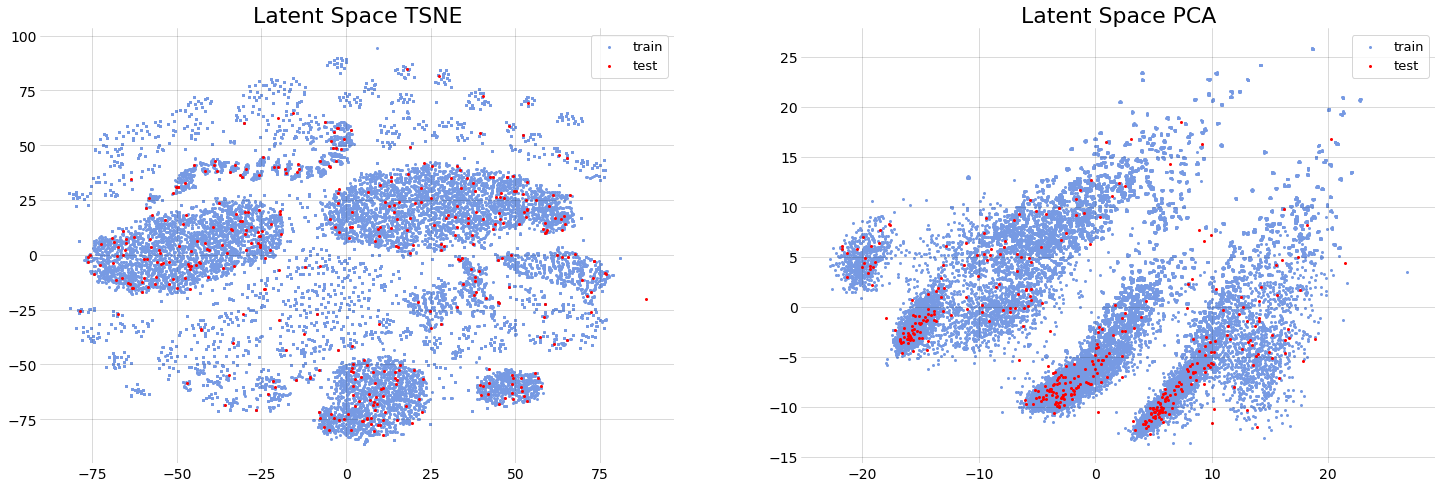

In [5]:
#latent spaces from train and test datasets

#train 
h_train = t.VAE.encoder(dataset.data)
q_train = t.VAE.lsr(h_train)
z_train = q_train.rsample()
z_train = z_train.detach().numpy()

#test 
h_test = t.VAE.encoder(test.data)
q_test = t.VAE.lsr(h_test)
z_test = q_test.rsample()
z_test = z_test.detach().numpy()

Z = np.concatenate((z_train, z_test), axis=0)
Z_embedded1 = TSNE(n_components=2).fit_transform(Z)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded2 = pca.transform(Z)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1,2, figsize=(25, 8))

    ax[0].scatter(Z_embedded1[:-len(test), 0], Z_embedded1[:-len(test), 1], s=4, label = "train")
    ax[0].scatter(Z_embedded1[-len(test):, 0], Z_embedded1[-len(test):, 1], s=4, c='red', label = "test")
    ax[0].title.set_text("Latent Space TSNE")
    ax[0].legend()

    ax[1].scatter(Z_embedded2[:-len(test), 0], Z_embedded2[:-len(test), 1], s=4, label = "train")
    ax[1].scatter(Z_embedded2[-len(test):, 0], Z_embedded2[-len(test):, 1], s=4, c='red', label = "test")
    ax[1].title.set_text("Latent Space PCA")
    ax[1].legend()

    plt.show()

Explained variance ratio :  [0.21218197 0.17424189]
Clustering done
traffic :  0
traffic :  1
traffic :  2
traffic :  3


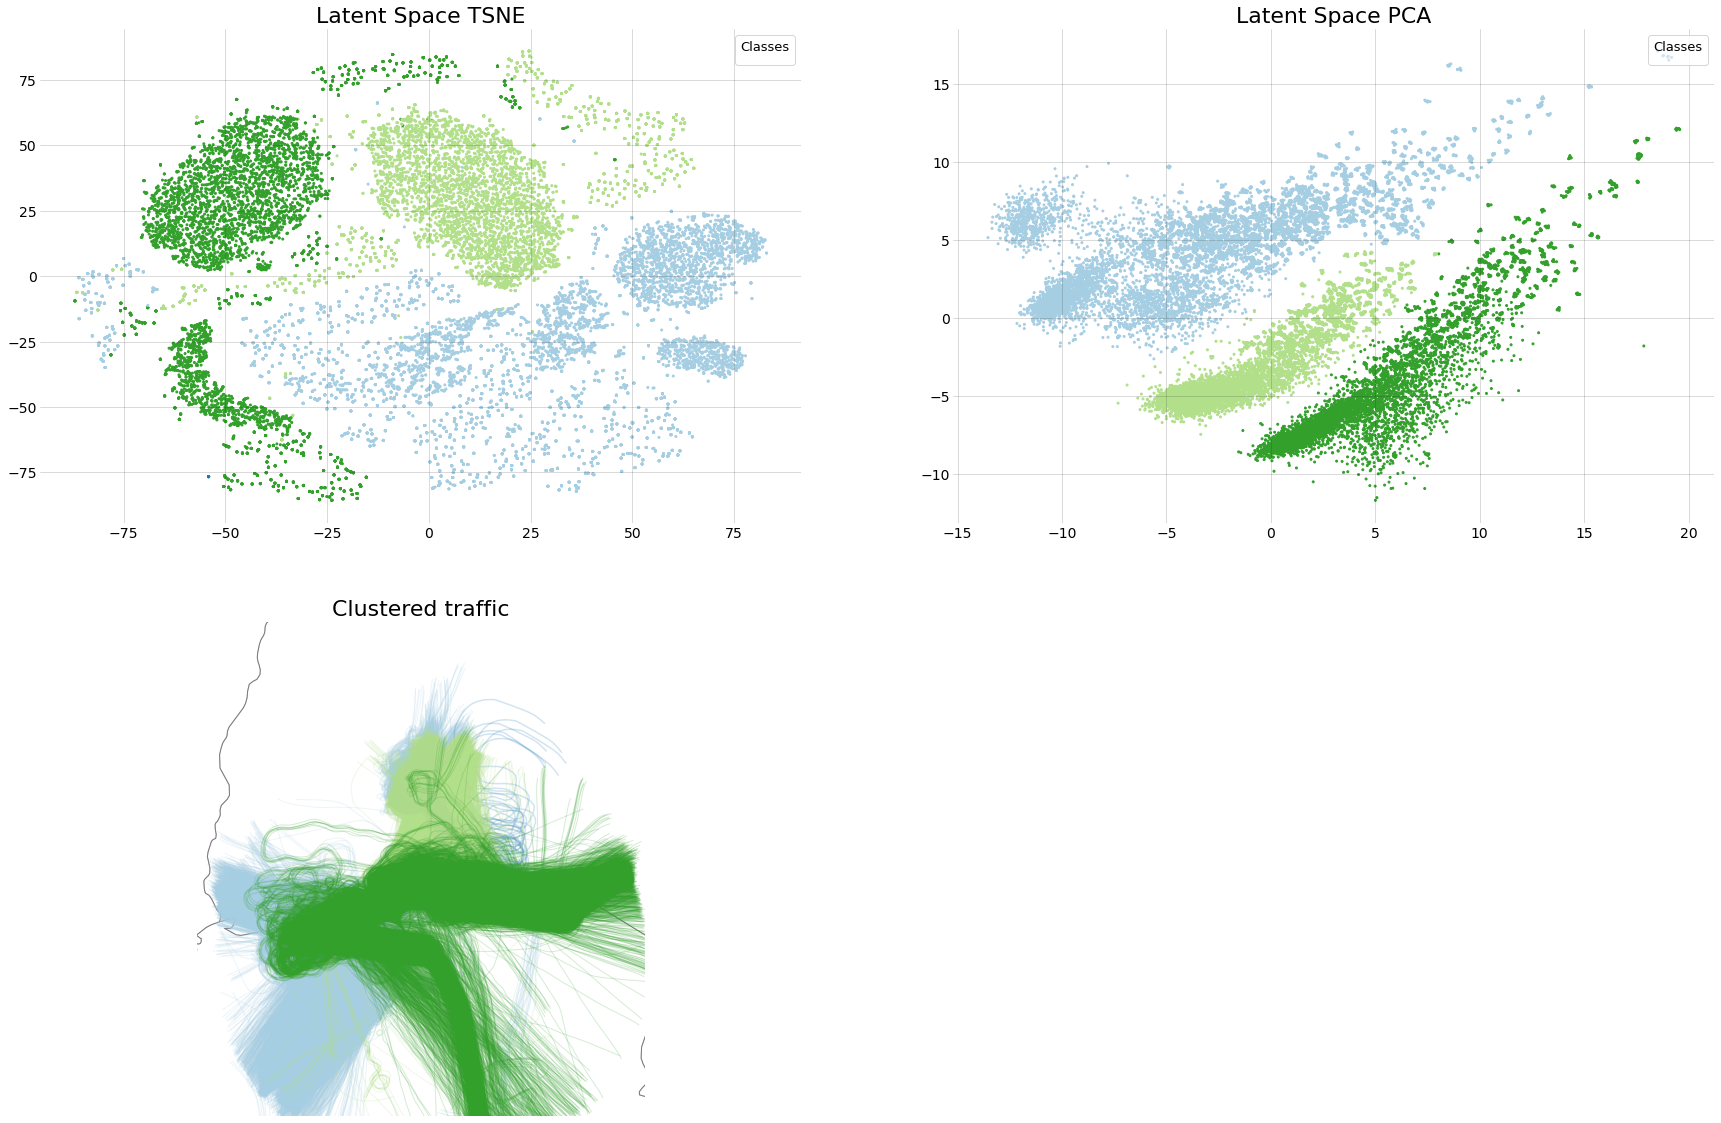

In [6]:
from sklearn.cluster import KMeans, SpectralClustering
from itertools import islice, cycle
from traffic.core.projection import EuroPP
from traffic.drawing import countries

n_gen = 1
Z = t.latent_space(n_gen)

Z_embedded1 = TSNE(n_components=2).fit_transform(Z)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded2 = pca.transform(Z)

print("Explained variance ratio : ", pca.explained_variance_ratio_)

cluster = SpectralClustering(n_clusters=4, random_state=0).fit(Z_embedded2[:,:2])
# cluster = KMeans(n_clusters=4, random_state=0).fit(Z_embedded2[:,:2])
print("Clustering done")

traffics = []
for i in np.unique(cluster.labels_):
    print("traffic : ", i)
    decoded = t.decode(torch.Tensor(Z[cluster.labels_ == i]))
    traffics.append(g.build_traffic(decoded, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False))


color_cycle = "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c #fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
colors = [color_cycle[i] for i in cluster.labels_]

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(223, projection=EuroPP())
    

    scat1 = ax0.scatter(Z_embedded1[:, 0], Z_embedded1[:, 1], s=4, c = colors)
    ax0.title.set_text("Latent Space TSNE")
    legend1 = ax0.legend(*scat1.legend_elements(),
                    loc="upper right", title="Classes")

    scat2 = ax1.scatter(Z_embedded2[:, 0], Z_embedded2[:, 1], s=4, c = colors)
    ax1.title.set_text("Latent Space PCA")
    legend2 = ax1.legend(*scat2.legend_elements(),
                    loc="upper right", title="Classes")

    ax2.add_feature(countries())
    ax2.figure
    ax2.set_extent((7.5, 9.5, 47, 48.5))
    ax2.title.set_text("Clustered traffic")
    for i, t in enumerate(traffics) :
        t.plot(ax2, alpha=0.2, color = color_cycle[i])

    plt.show()

In [8]:
# Likelyhood train/test within prior

h_train = t.VAE.encoder(dataset.data)
q_train = t.VAE.lsr(h_train)
z_train = q_train.rsample()

h_test = t.VAE.encoder(test.data)
q_test = t.VAE.lsr(h_test)
z_test = q_test.rsample()

prior = t.VAE.lsr.get_prior()

print(prior.log_prob(z_train).mean())
print(prior.log_prob(z_test).mean())

tensor(-25.0649, grad_fn=<MeanBackward0>)
tensor(-35.0627, grad_fn=<MeanBackward0>)


In [ ]:
from scipy.spatial.distance import cdist
from tqdm.autonotebook import tqdm
import pandas as pd

#e-distance

def energy_distance(x, y):

    """Compute energy distance between the distributions of 2 samples of different length
    """
    n1 = x.shape[0]
    n2 = y.shape[0]
    a = cdist(x, y, "euclidean").mean()
    b = cdist(x, x, "euclidean").mean()
    c = cdist(y, y, "euclidean").mean()
    e = (n1 * n2 / (n1 + n2)) * (2 * a - b - c)
    return e

print(energy_distance(z_train.detach().numpy(), z_test.detach().numpy()))

B = 100

def Etest(dataset1, dataset2, B):
    n1 = len(dataset1)
    n2 = len(dataset2)
    ek = 0
    e0 = energy_distance(dataset1, dataset2)
    pop = np.array(pd.concat([dataset1, dataset2], ignore_index=True))
    for i in tqdm(range(B)):
        np.random.shuffle(pop)
        eb = energy_distance(pop[:n1, :], pop[n1:, :])
        if eb > e0:
            ek += 1

    return e0, (ek + 1) / (B + 1)


Etest(pd.DataFrame(z_train.detach().numpy()), pd.DataFrame(z_test.detach().numpy()), B)

In [5]:
prior = t.VAE.lsr.get_prior()
# prior.mixture_distribution.logits
# prior.component_distribution.base_dist.loc
prior.component_distribution.base_dist.scale

tensor([[0.0498, 0.3417, 0.4182,  ..., 0.6316, 0.1593, 0.2215],
        [0.0498, 0.3652, 0.3019,  ..., 0.5922, 0.2595, 0.3934],
        [0.0498, 0.5863, 0.2499,  ..., 0.2245, 0.5882, 0.1652],
        ...,
        [0.0498, 0.3477, 0.2602,  ..., 0.6224, 0.2167, 0.3014],
        [0.0498, 0.3813, 0.2001,  ..., 0.4090, 0.1680, 0.2123],
        [0.0498, 0.2948, 0.2732,  ..., 0.5050, 0.2394, 0.3055]],
       grad_fn=<ExpBackward>)

In [10]:
#Likelyhood train/test within the empirical aggregated posterior

params = t.VAE.lsr.dist_params(q_train)

mix = torch.distributions.Categorical(logits = torch.ones(h_train.shape[0]))
comp = torch.distributions.Independent(torch.distributions.Normal(params[0], params[1]), 1)
gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)

print(gmm.log_prob(z_train[:2000]).mean())
print(gmm.log_prob(z_test[:2000]).mean())

tensor(87.9101, grad_fn=<MeanBackward0>)
tensor(-5121.4404, grad_fn=<MeanBackward0>)


In [11]:
#variance of the encoded means
#If the variance is high enough, the dimensions is active
#if not, the dimension is inactive (threshold = 0.01)

#For latent space = 256 : only 209 active dimensions
#For latent space = 150 : only 146 active dimensions
#For latent space = 64 : every 64 dimensions are active

var_dims = params[0].var(axis = 0)
torch.sum(var_dims > 0.01)

tensor(57)

## Standard Gaussian Ring (only for gaussian prior)

In [17]:
# Are the latent means really next to the ring of standard gaussian in dimension 256 ?

quant = 3.69 #comme c'est 2 sided ca va nous donner une proba a 0.9998 alors que c'est le quantile 0.9999
up = np.sqrt(t.VAE.lsr.out_dim) + quant/np.sqrt(2)
down = np.sqrt(t.VAE.lsr.out_dim) - quant/np.sqrt(2)
print("range of norms : ", down, up)

#parameters of latent space distributions
h = t.VAE.encoder(dataset.data)
# h = t.VAE.encoder(test.data)
q = t.VAE.lsr(h)
params = t.VAE.lsr.dist_params(q)
means_norms = np.linalg.norm(params[0].detach().numpy(), ord = 2, axis = 1)
mask = (means_norms < up) & (means_norms > down)
print("proportion of means well located for a standard gaussian :", mask.sum()/len(mask))
print("quantiles 0.25, 0.5 and 0.75 of means : ", np.quantile(means_norms, [0.25, 0.5, 0.75]))

#NOPE
#Il y en a plus proche de 0, et certains plus loins, mais peu dans la bonne fenetre
#En dimension 256 tout est très dilaté, et donc l'espace est trop grand 

range of norms :  5.39077597742164 10.60922402257836
proportion of means well located for a standard gaussian : 0.2547857142857143
quantiles 0.25, 0.5 and 0.75 of means :  [ 4.41904938  5.2574687  10.09622598]


In [18]:
#empirical propability within the bounds of the posteriori distribution 
mix = torch.distributions.Categorical(torch.ones(len(dataset.data),))
comp = torch.distributions.Independent(torch.distributions.Normal(params[0], params[1]), 1)
gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)
z = gmm.sample(sample_shape=torch.Size([10000]))

z_norms = np.linalg.norm(z.detach().numpy(), ord = 2, axis = 1)
z_mask = (z_norms < up) & (z_norms > down)
print("proportion of points from the posteriori between the bounds : ", z_mask.sum()/len(z_mask))

proportion of points from the posteriori between the bounds :  0.2698


## Marginals within the latent space (Only for gaussian prior)

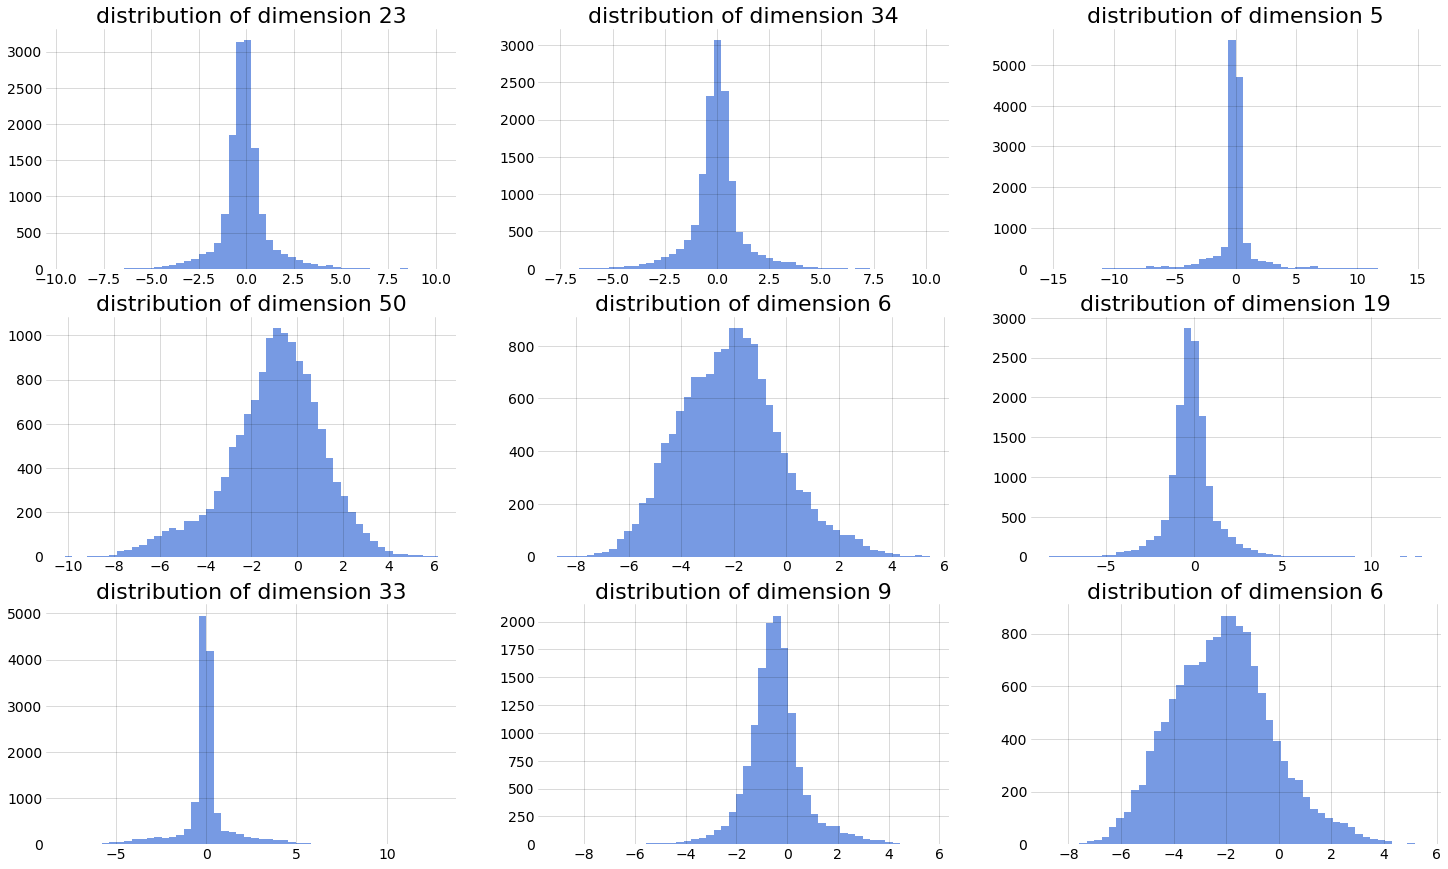

In [87]:
#Are each dimension normally distributed ? plot the histogram of each of 256 dimensions
#Distributions of the means of posterior along each dimension

h_train = t.VAE.encoder(dataset.data)
q_train = t.VAE.lsr(h_train)
params = t.VAE.lsr.dist_params(q_train)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(3, 3, figsize=(25, 15))
    for i in np.arange(0,3):
        for j in np.arange(0,3):
            k = np.random.randint(0, t.VAE.lsr.out_dim)
            ax[i,j].hist(params[0][:,k].detach().numpy(), bins = 50)
            ax[i,j].title.set_text("distribution of dimension "+str(k))

In [23]:
from scipy.stats import kstest

#testing the normality of the distribution of the means along each dimension
#p_value = proba to observe a most extreme value than the one observed with the stat under the null hypothesis
#low p_value -> reject null
p_values = []

for i in range(t.VAE.lsr.out_dim):
    stat, p_value = kstest(params[0][:,i].detach().numpy(), "norm")
    p_values.append(p_value)

print("Greatest p_value for the normality test :", np.max(p_values))
print("Number of p_values above 0.05 :", np.sum(np.array(p_values)>0.05))
#despite the histograms, none of the dimensions are normaly distributed

Greatest p_value for the normality test : 0.2125586033323661
Number of p_values above 0.05 : 1


# Pseudo-Inputs

In [6]:
#Computing the pseudo inputs

#Vampprior
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X = pseudo_X.view((pseudo_X.shape[0], 4, 200))

#Exemplar
# pseudo_X = t.VAE.lsr.prior_trajs

pseudo_h = t.VAE.encoder(pseudo_X)
pseudo_means = t.VAE.lsr.z_loc(pseudo_h)

#Vampprior
pseudo_scales = (t.VAE.lsr.z_log_var(pseudo_h) / 2).exp()

#Exemplar
# pseudo_scales = t.VAE.lsr.prior_vars

#The pseudo-inputs themselves don't have any meaning; they are not realistic trajectories at all
#They have meanings once they are put through the decoder
#So the entire VAE is able to reconstruct sensible trajectories event though the input is not a trajectory but has the good properties
#That's impossible to plot the pseudo inputs trajectories per se

# pseudo_X[0] #VS dataset.data[0]

  95% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 946/1,000  [ 0:00:03 < 0:00:01 , 254 it/s ]

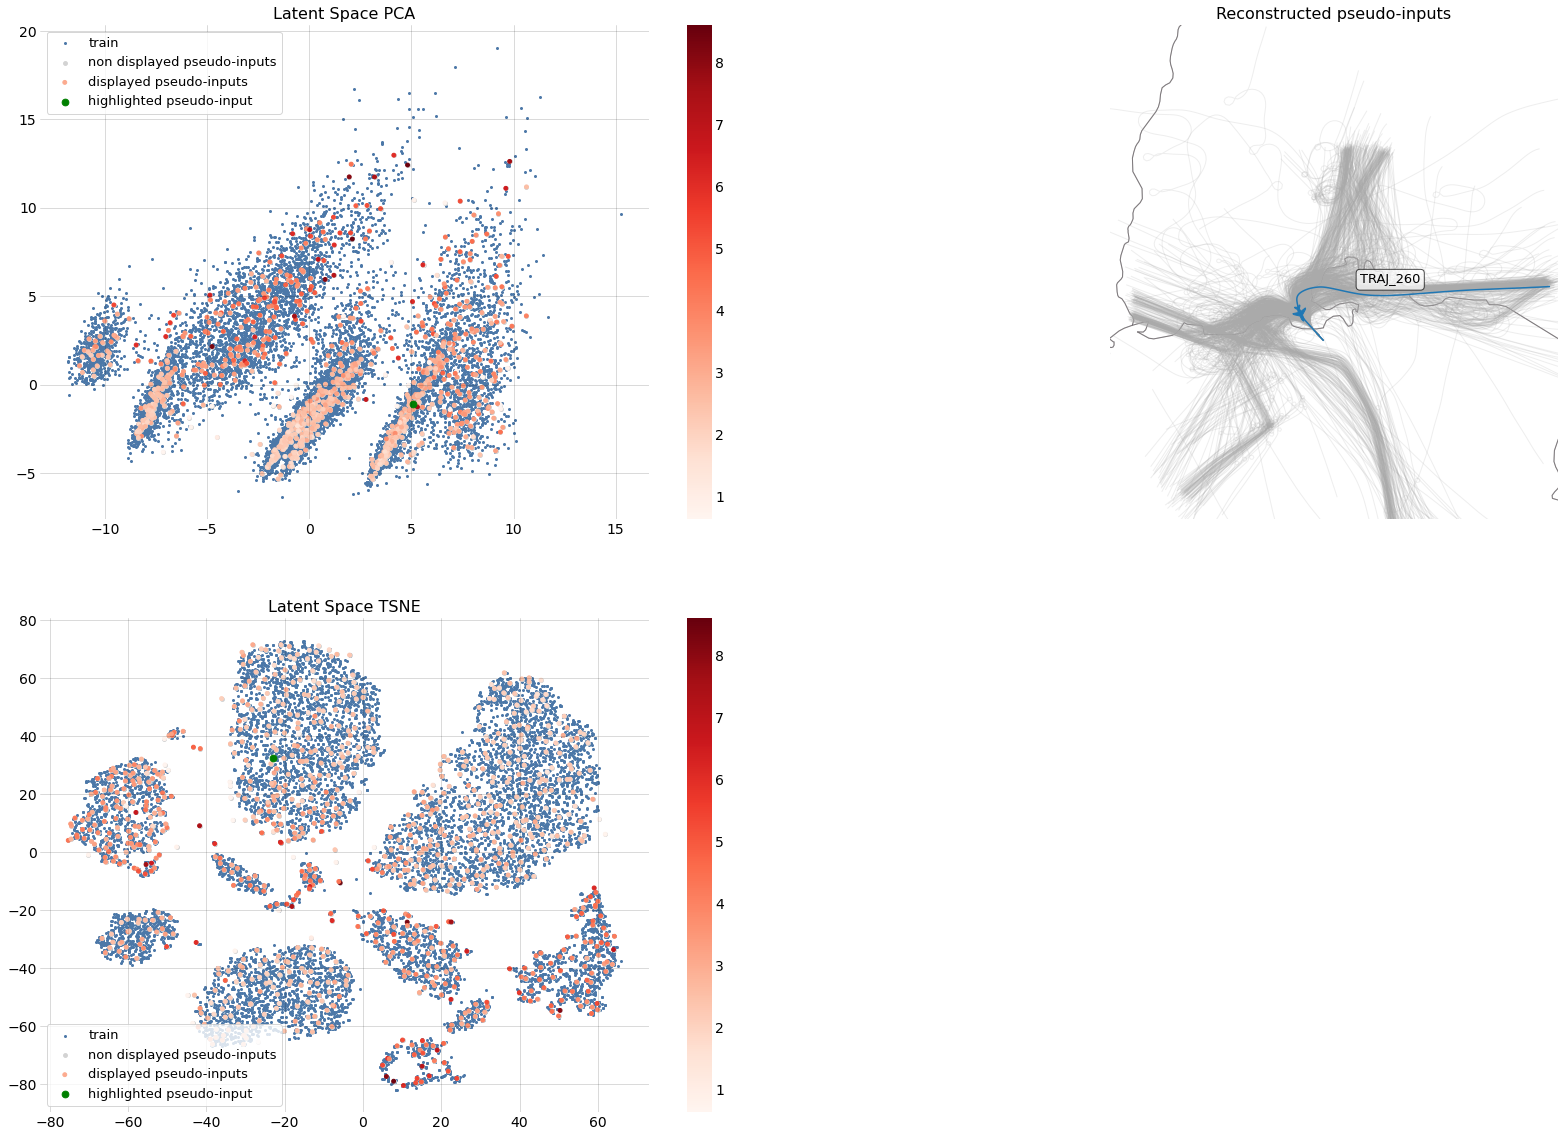

In [8]:
#Plot of the reconstructed pseudo-inputs
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from scipy.signal import savgol_filter

#Reconstructed pseudo-inputs
out = t.decode(pseudo_means)
#Neural net don't predict exaclty timedelta = 0 for the first observation
out[:,3] = 0
#The track prediction is filtered (smoothen trajectories)
out[:,0::4] = savgol_filter(out[:,0::4], 11, 3)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

#loops
def simple(flight):
    return flight.assign(simple=lambda x: flight.shape.is_simple)
out_traf = out_traf.iterate_lazy().pipe(simple).eval(desc ="")
# out_traf = out_traf.query("not simple")

#pseudo-inputs
# out = dataset.scaler.inverse_transform(pseudo_X.transpose(1, 2).reshape((pseudo_X.shape[0], -1)).detach().numpy())
# out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

#latent spaces from train dataset and pseudo_inputs
h_train = t.VAE.encoder(dataset.data)
q_train = t.VAE.lsr(h_train)
z_train = q_train.rsample()
z_train = z_train.detach().numpy()

Z = np.concatenate((z_train, pseudo_means.detach().numpy()), axis=0)
Z_embedded1 = TSNE(n_components=2).fit_transform(Z)

pca = PCA(n_components=2).fit(Z[:-len(pseudo_means)])
Z_embedded2 = pca.transform(Z)

#col depending on the scales
# col = torch.norm(pseudo_scales, dim = 1, p = float("inf")).detach().numpy()
col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())
    ax2 = fig.add_subplot(223)

    fidx = list(map(lambda x: int(x.split("_")[1]),out_traf.flight_ids))
    k = np.random.choice(fidx)
    fidx = np.array(fidx) + len(z_train)

    # k =  np.random.randint(len(out_traf))
    # k = 111 

    ax2.scatter(Z_embedded1[:-len(pseudo_means), 0], Z_embedded1[:-len(pseudo_means), 1], s=4, label = "train")
    points0 = ax2.scatter(Z_embedded1[-len(pseudo_means):, 0], Z_embedded1[-len(pseudo_means):, 1], s=15, c="lightgrey", label = "non displayed pseudo-inputs")
    points1 = ax2.scatter(Z_embedded1[fidx, 0], Z_embedded1[fidx, 1], s=15, c=col[fidx - len(z_train)], cmap = "Reds",  label = "displayed pseudo-inputs")
    ax2.scatter(Z_embedded1[(len(z_train)+k), 0], Z_embedded1[(len(z_train)+k), 1], s=45, c='green', label = "highlighted pseudo-input")
    ax2.title.set_text("Latent Space TSNE")
    ax2.legend()
    fig.colorbar(points1, ax=ax2)

    ax0.scatter(Z_embedded2[:-len(pseudo_means), 0], Z_embedded2[:-len(pseudo_means), 1], s=4, label = "train")
    points0 = ax0.scatter(Z_embedded2[-len(pseudo_means):, 0], Z_embedded2[-len(pseudo_means):, 1], s=15, c="lightgrey", label = "non displayed pseudo-inputs")
    points1 = ax0.scatter(Z_embedded2[fidx, 0], Z_embedded2[fidx, 1], s=15, c=col[fidx - len(z_train)], cmap = "Reds",  label = "displayed pseudo-inputs")
    ax0.scatter(Z_embedded2[(len(z_train)+k), 0], Z_embedded2[(len(z_train)+k), 1], s=45, c='green', label = "highlighted pseudo-input")
    ax0.title.set_text("Latent Space PCA")
    ax0.legend()
    fig.colorbar(points1, ax=ax0)

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    ax1.title.set_text("Reconstructed pseudo-inputs")
    out_traf.plot(ax1, alpha=0.2)
    out_traf["TRAJ_"+str(k)].plot(ax1, color="#1f77b4", lw=1.5)
    out_traf["TRAJ_"+str(k)].at_ratio(0.85).plot(
        ax1,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

Evaluation of pseudo-inputs trajectories : 
- time between self intersecting point
- number od points given by douglas-peucker simplification / difference between cumdist and dist compared to real dataset
- Locations of self intersectig points within real dataset and see if pseudo-inputs are intersecting within these zones
- max heading rate / altitude rate / groundspeed rate within real dataset

In [14]:
from shapely.ops import unary_union
import collections

#gives coordinate of self-intersecting points

mls = unary_union(out_traf["TRAJ_360"].shape)

coords_list = []
for non_itersecting_ls in mls:
    coords_list.extend(non_itersecting_ls.coords)

print([item for item, count in collections.Counter(coords_list).items() if count > 1])

[(8.385968241439938, 47.59657597923784, 4422.378515955374), (8.447828301243852, 47.627750702954884, 3917.2071052554115)]


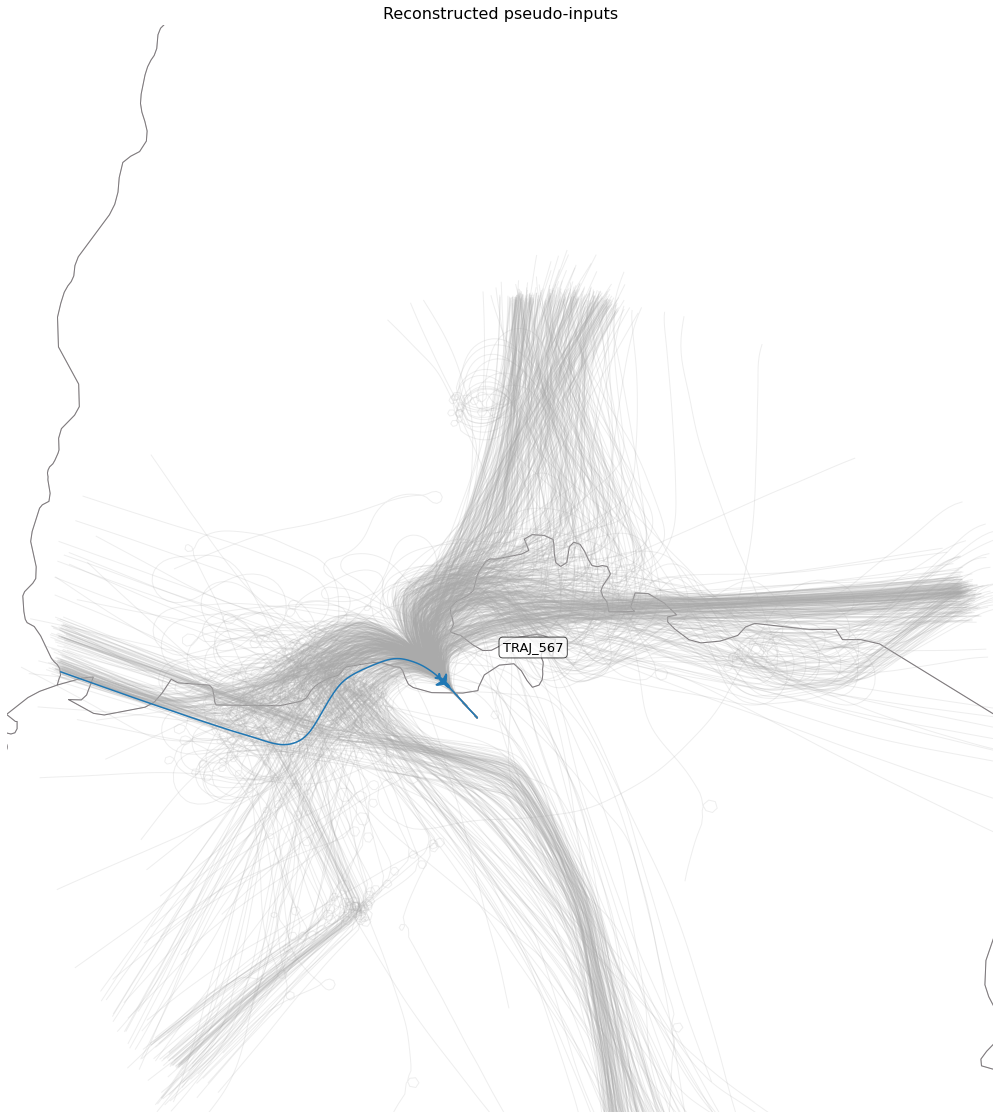

In [17]:
from traffic.data import airports

def within50(flight):
    g = flight.query("distance > 45")
    if g is None:
        return flight
    else :
        return None


a = out_traf.distance(airports["LSZH"]).pipe((within50)).eval(max_workers=50)

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax1 = fig.add_subplot(111, projection=EuroPP())

    fidx = list(map(lambda x: int(x.split("_")[1]),a.flight_ids))
    k = np.random.choice(fidx)

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    ax1.title.set_text("Reconstructed pseudo-inputs")
    a.plot(ax1, alpha=0.2)
    a["TRAJ_"+str(k)].plot(ax1, color="#1f77b4", lw=1.5)
    a["TRAJ_"+str(k)].at_ratio(0.85).plot(
        ax1,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

  89% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 163/184  [ 0:00:01 < 0:00:01 , 131 it/s ]

Index(['TRAJ_30'], dtype='object', name='flight_id')


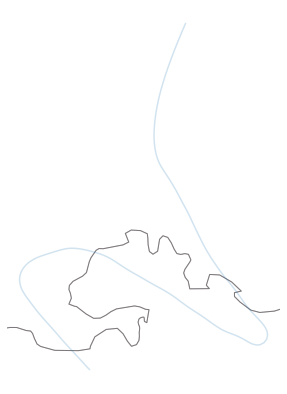

In [17]:
import pandas as pd

#Gives difference betwwen dist in traight line and actual distance

#cummulative distance
out_traf = out_traf.cumulative_distance().eval(desc = "")
cumdist = out_traf.data.groupby(["flight_id"]).cumdist.max()

#distance between start and stop
dict_dist = {}
for f in out_traf:
    dict_dist[f.flight_id] = f.distance()
dists = pd.Series(data = dict_dist, index = out_traf.flight_ids) 

ratio = cumdist/dists
with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    out_traf[ratio[ratio > 2].index].plot(ax, alpha=0.2, color="#1f77b4")

print(ratio[ratio > 2].index)

In [43]:
#Sorting trajectories in function of the number of points within simplification

simp = out_traf.simplify(200).eval(desc ="", max_workers =50)

dict_len = {}
for f in simp:
    dict_len[f.flight_id] = len(f)

f_len = pd.Series(dict_len).sort_values(ascending = False)

  0%|          | 0/500 [00:00<?, ?it/s]

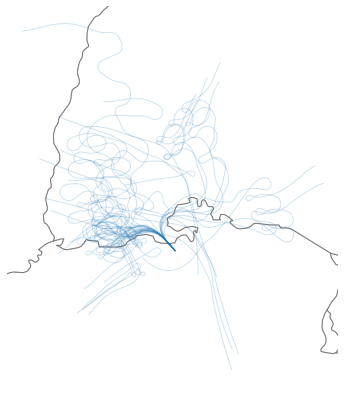

In [56]:
with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    out_traf[f_len[:30].index].plot(ax, alpha=0.2, color="#1f77b4")

In [75]:
# heading change rate and curvature
from tqdm.autonotebook import tqdm

out_traf = out_traf.compute_xy()

def curvature(x, y):
    x_t = np.gradient(x)
    y_t = np.gradient(y)
    xx_t = np.gradient(x_t)
    yy_t = np.gradient(y_t)

    return (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t) ** (3 / 2)

head_rate_max = {}
max_curv = {}

for f in tqdm(out_traf) :
    head_rate_max[f.flight_id] = np.abs(f.data.track.diff(periods = 1)).max()
    max_curv[f.flight_id] = curvature(f.data.x, f.data.y).max()

head_rate_max = pd.Series(head_rate_max).sort_values(ascending = False)
max_curv = pd.Series(max_curv).sort_values(ascending = False)



  0%|          | 0/500 [00:00<?, ?it/s]

In [81]:
head_rate_max

TRAJ_464    76.103399
TRAJ_361    71.248814
TRAJ_271    71.122233
TRAJ_86     70.589880
TRAJ_429    70.373390
              ...    
TRAJ_97      1.926285
TRAJ_67      1.900226
TRAJ_161     1.756728
TRAJ_410     1.752873
TRAJ_113     1.271687
Length: 500, dtype: float64

In [76]:
max_curv

TRAJ_360    0.003429
TRAJ_222    0.002956
TRAJ_104    0.002873
TRAJ_128    0.002651
TRAJ_221    0.002639
              ...   
TRAJ_378    0.000013
TRAJ_395    0.000011
TRAJ_232    0.000010
TRAJ_289    0.000009
TRAJ_161    0.000009
Length: 500, dtype: float64

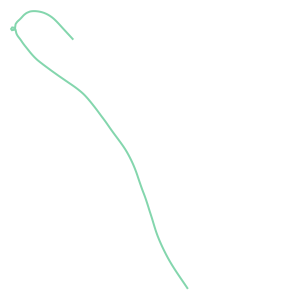

In [83]:
out_traf["TRAJ_361"]

<AxesSubplot:>

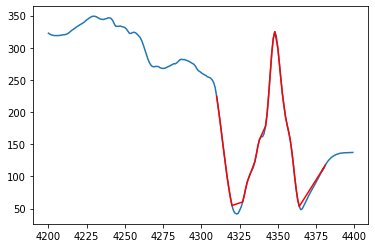

In [66]:
a = np.where(np.abs(out_traf["TRAJ_222"].data.track.diff(periods = 1)) > 8) 

out_traf["TRAJ_21"].data.track.plot()
out_traf["TRAJ_21"].data.track.iloc[a].plot(color = "r")


In [19]:
import altair as alt
import pandas as pd

#Projection of means
pca_means = PCA(n_components=2).fit(z_train)
means_embedded = pd.DataFrame(pca_means.transform(pseudo_means.detach().numpy()), columns = ["PC0", "PC1"])
means_embedded["flight_id"] = ["TRAJ_" + str(i) for i in range(len(pseudo_means))]
means_embedded["scale"] = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

alt.Chart(means_embedded).mark_circle(size=60).encode(
    x='PC0',
    y='PC1',
    color=alt.Color(
        "scale", scale=alt.Scale(scheme="spectral")),
    tooltip=['flight_id', "scale"]
).interactive()

alt.Chart(...)

In [195]:
import plotly.express as px

traj = out_traf[['TRAJ_204', 'TRAJ_206', 'TRAJ_410', 'TRAJ_42', 'TRAJ_486', 'TRAJ_60',
       'TRAJ_669', 'TRAJ_720', 'TRAJ_777']].data

traj["Time"] = traj["timestamp"].apply(lambda x: x.strftime("%H:%M:%S"))

px.set_mapbox_access_token(
    "pk.eyJ1IjoiZmlndSIsImEiOiJja2JndjNoaDQwYnl6MnJwM2tzNG9vcHc2In0.Ru9xsbyaKn7BNvIYAwPwUg"
)

fig = px.scatter_mapbox(
    traj,
    lat="latitude",
    lon="longitude",
    animation_frame="Time",
    animation_group="flight_id",
    hover_name="flight_id",
    size="altitude",
)

for ids in traj.flight_id.unique():
    fig.add_traces(
        px.line_mapbox(
            traj[traj.flight_id == ids], lat="latitude", lon="longitude"
        ).data[0]
    )

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100

fig.show(renderer='notebook_connected')

<ipython-input-195-2215041042eb>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[701 576]
red scale : tensor(4.4159, grad_fn=<SelectBackward>)
green scale : tensor(4.6028, grad_fn=<SelectBackward>)


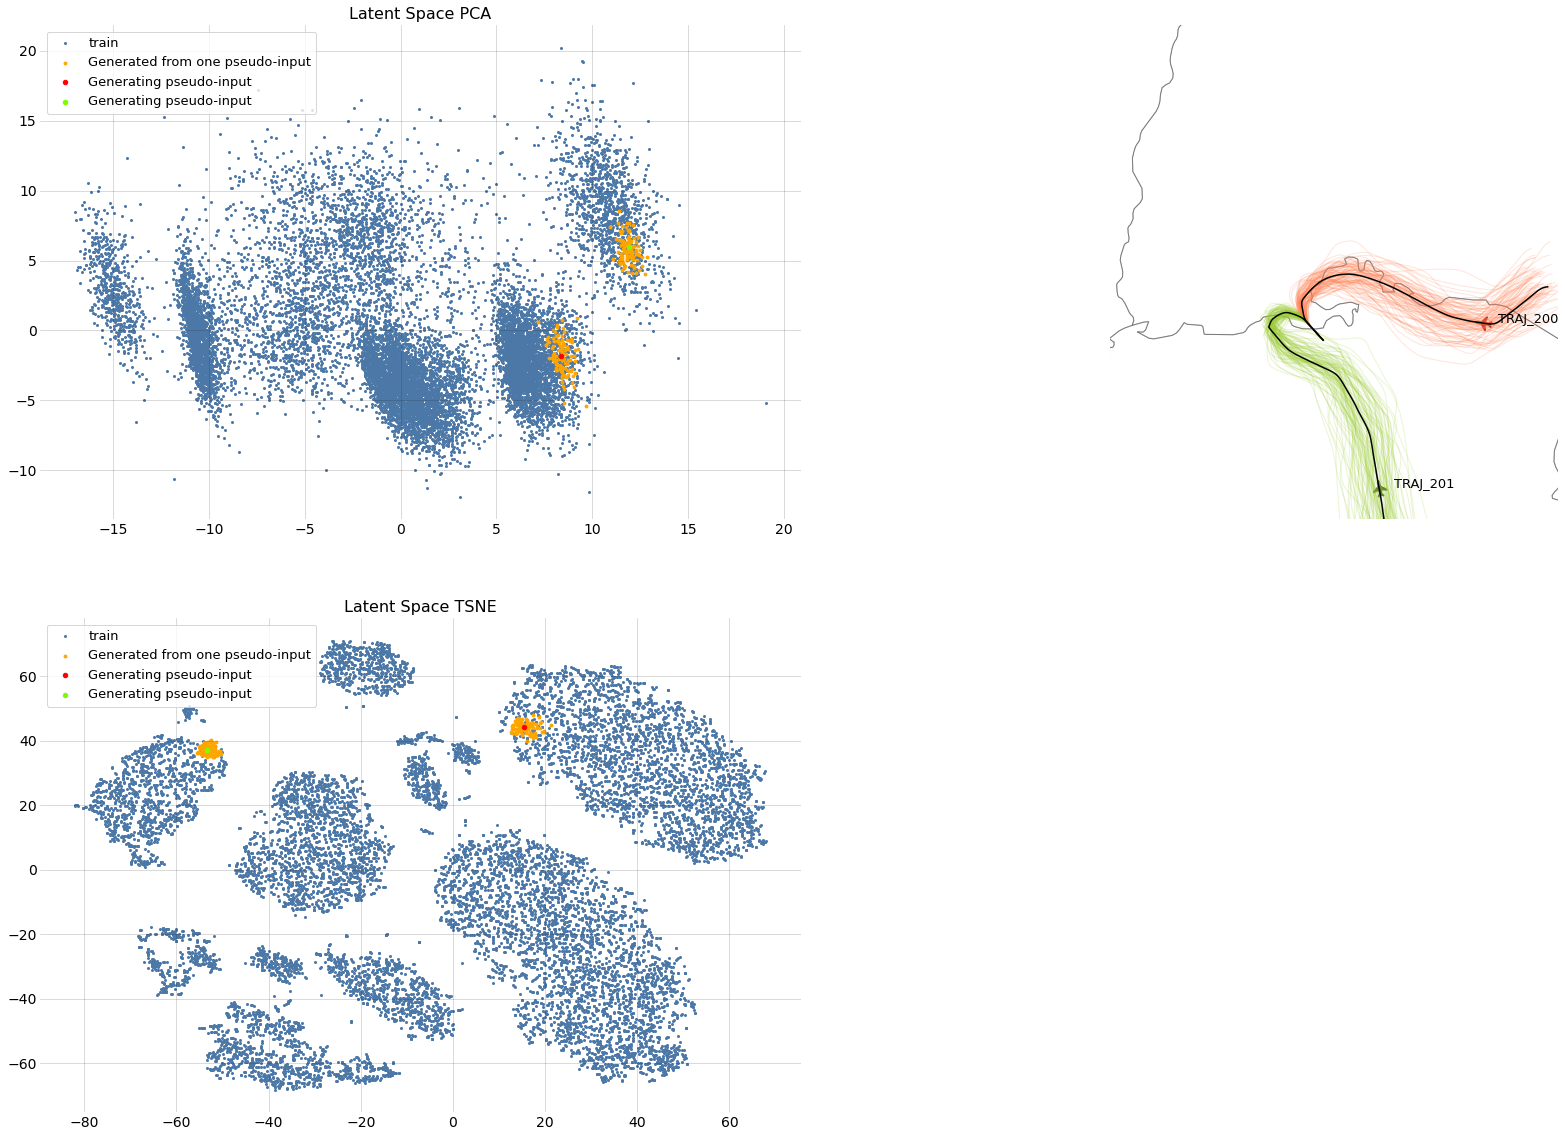

In [20]:
i = np.random.randint(int(len(pseudo_means)/2))

col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()
js = np.argsort(col)[[i,-i]]

n_gen = 100

dist1 = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[js[0]], pseudo_scales[js[0]]), 1)
gen1 = dist1.sample(torch.Size([n_gen]))

dist2 = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[js[1]], pseudo_scales[js[1]]), 1)
gen2 = dist2.sample(torch.Size([n_gen]))

gen = torch.cat((gen1, gen2, pseudo_means[js]), axis=0)
out = t.decode(gen)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

concat = np.concatenate((z_train, gen.detach().numpy()))
gen_embedded1 = TSNE(n_components=2).fit_transform(concat)

pca = PCA(n_components=2).fit(concat[:-len(gen)])
gen_embedded2 = pca.transform(concat)

print(js)
col = torch.norm(pseudo_scales[js], dim = 1, p = 2)
print("red scale :", col[0])
print("green scale :", col[1])

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())
    ax2 = fig.add_subplot(223)

    ax2.scatter(gen_embedded1[:-len(gen), 0], gen_embedded1[:-len(gen), 1], s=4, label = "train")
    ax2.scatter(gen_embedded1[-len(gen):, 0], gen_embedded1[-len(gen):, 1], s=8, c='orange', label = "Generated from one pseudo-input")
    ax2.scatter(gen_embedded1[-2, 0], gen_embedded1[-2, 1], s=20, c='red', label = "Generating pseudo-input")
    ax2.scatter(gen_embedded1[-1, 0], gen_embedded1[-1, 1], s=20, c="lawngreen", label = "Generating pseudo-input")
    ax2.title.set_text("Latent Space TSNE")
    ax2.legend()

    ax0.scatter(gen_embedded2[:-len(gen), 0], gen_embedded2[:-len(gen), 1], s=4, label = "train")
    ax0.scatter(gen_embedded2[-len(gen):, 0], gen_embedded2[-len(gen):, 1], s=8, c='orange', label = "Generated from one pseudo-input")
    ax0.scatter(gen_embedded2[-2, 0], gen_embedded2[-2, 1], s=20, c='red', label = "Generating pseudo-input")
    ax0.scatter(gen_embedded2[-1, 0], gen_embedded2[-1, 1], s=20, c="lawngreen", label = "Generating pseudo-input")
    ax0.title.set_text("Latent Space PCA")
    ax0.legend()

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    out_traf[["TRAJ_" + str(i) for i in range(n_gen)]].plot(ax1, color="coral", alpha=0.2)
    out_traf[["TRAJ_" + str(i) for i in range(n_gen, n_gen*2)]].plot(ax1, color="yellowgreen", alpha=0.2)

    out_traf["TRAJ_"+str(len(out_traf)-2)].plot(ax1, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-2)].at_ratio(0.2).plot(
        ax1,
        color="firebrick",
    )

    out_traf["TRAJ_"+str(len(out_traf)-1)].plot(ax1, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-1)].at_ratio(0.2).plot(
        ax1,
        color="darkolivegreen",
    )

[141 543]
red scale : tensor(3.1153, grad_fn=<SelectBackward>)
green scale : tensor(3.2928, grad_fn=<SelectBackward>)


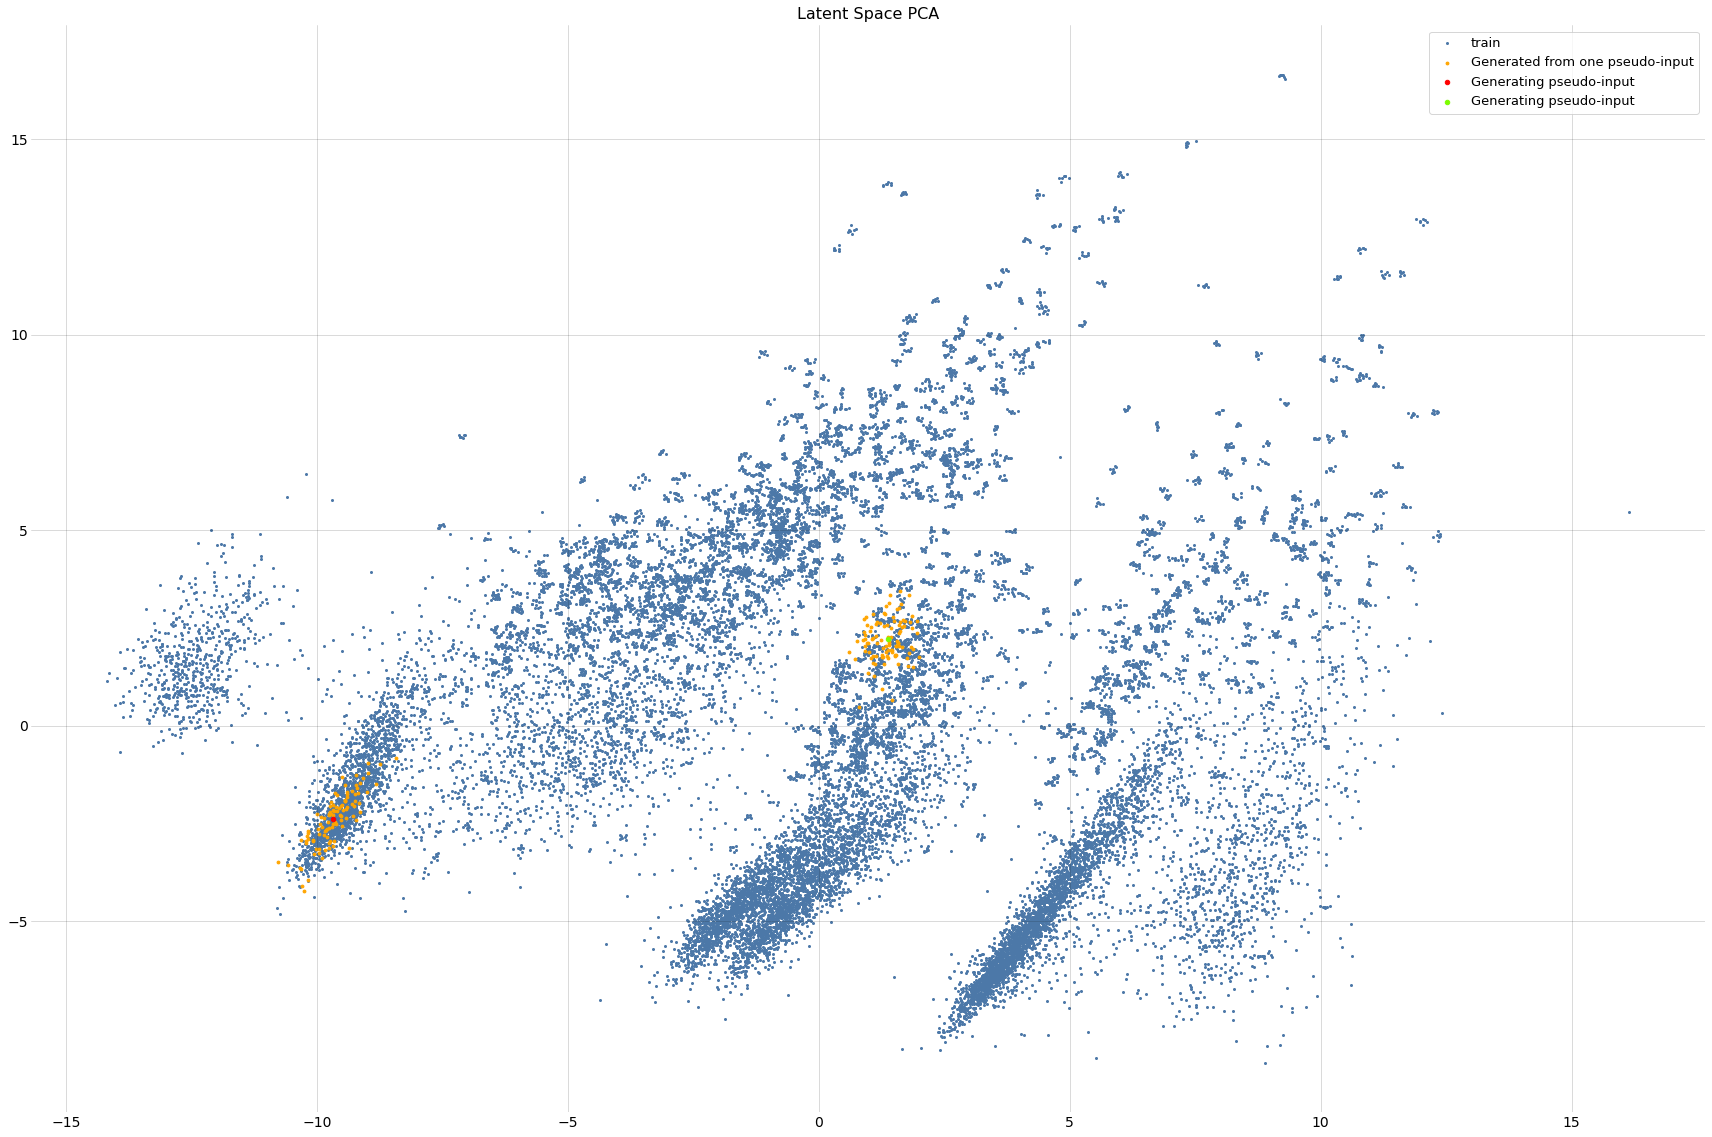

In [56]:
i = np.random.randint(int(len(pseudo_means)/2))

col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()
js = np.argsort(col)[[i,-i]]

n_gen = 100

dist1 = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[js[0]], pseudo_scales[js[0]]), 1)
gen1 = dist1.sample(torch.Size([n_gen]))

dist2 = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[js[1]], pseudo_scales[js[1]]), 1)
gen2 = dist2.sample(torch.Size([n_gen]))

gen = torch.cat((gen1, gen2, pseudo_means[js]), axis=0)
out = t.decode(gen)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

pca = PCA(n_components=2).fit(concat[:-len(gen)])
gen_embedded = pca.transform(concat)

print(js)
col = torch.norm(pseudo_scales[js], dim = 1, p = 2)
print("red scale :", col[0])
print("green scale :", col[1])

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111)

    ax.scatter(gen_embedded[:-len(gen), 0], gen_embedded[:-len(gen), 1], s=4, label = "train")
    ax.scatter(gen_embedded[-len(gen):, 0], gen_embedded[-len(gen):, 1], s=8, c='orange', label = "Generated from one pseudo-input")
    ax.scatter(gen_embedded[-2, 0], gen_embedded[-2, 1], s=20, c='red', label = "Generating pseudo-input")
    ax.scatter(gen_embedded[-1, 0], gen_embedded[-1, 1], s=20, c="lawngreen", label = "Generating pseudo-input")
    ax.title.set_text("Latent Space PCA")
    ax.legend()

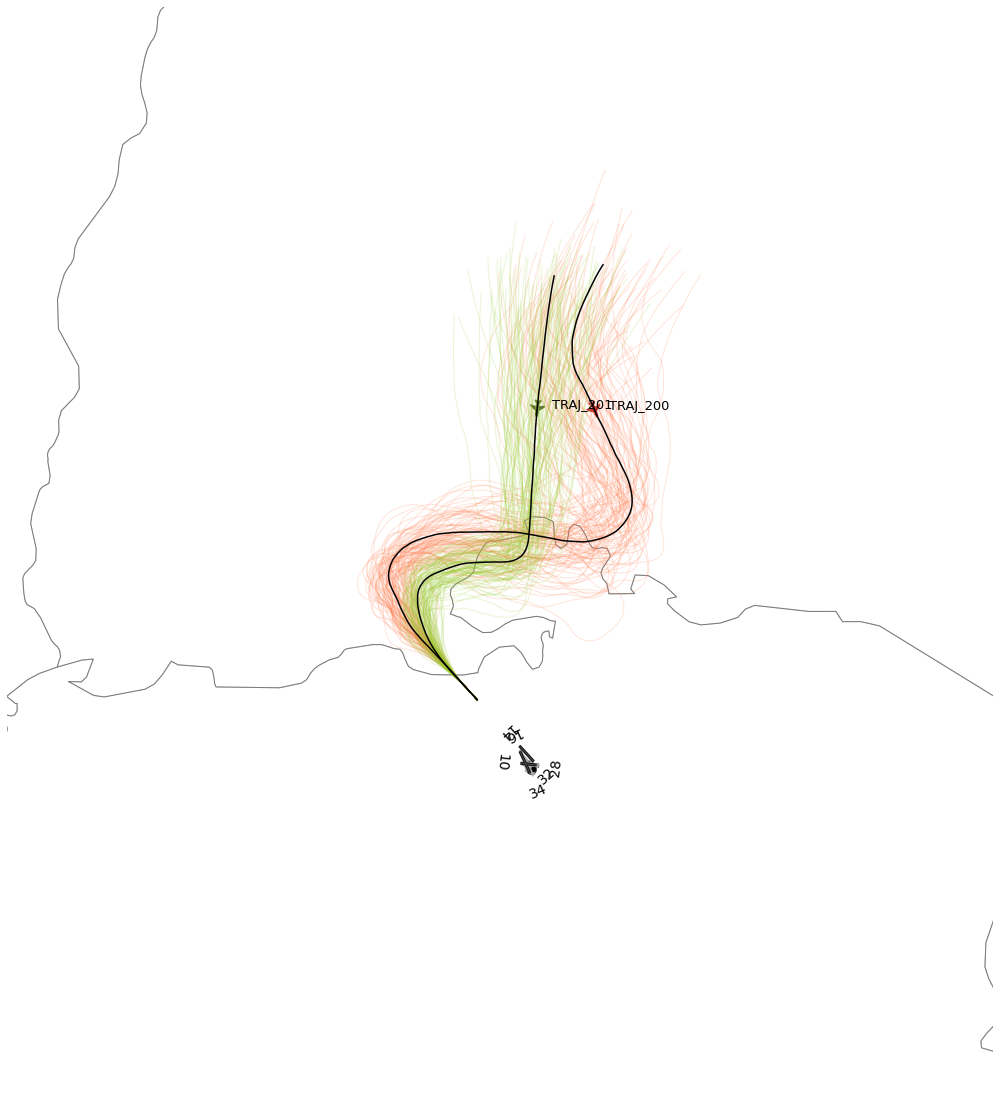

In [57]:
from traffic.data import airports

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111, projection=EuroPP())

    ax.add_feature(countries())
    ax.figure
    ax.set_extent((7.5, 9.5, 47, 48.5))
    out_traf[["TRAJ_" + str(i) for i in range(n_gen)]].plot(ax, color="coral", alpha=0.2)
    out_traf[["TRAJ_" + str(i) for i in range(n_gen, n_gen*2)]].plot(ax, color="yellowgreen", alpha=0.2)

    out_traf["TRAJ_"+str(len(out_traf)-2)].plot(ax, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-2)].at_ratio(0.2).plot(
        ax,
        color="firebrick",
    )

    out_traf["TRAJ_"+str(len(out_traf)-1)].plot(ax, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-1)].at_ratio(0.2).plot(
        ax,
        color="darkolivegreen",
    )

    airports["LSZH"].plot(ax, footprint=True, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

[  8 483]


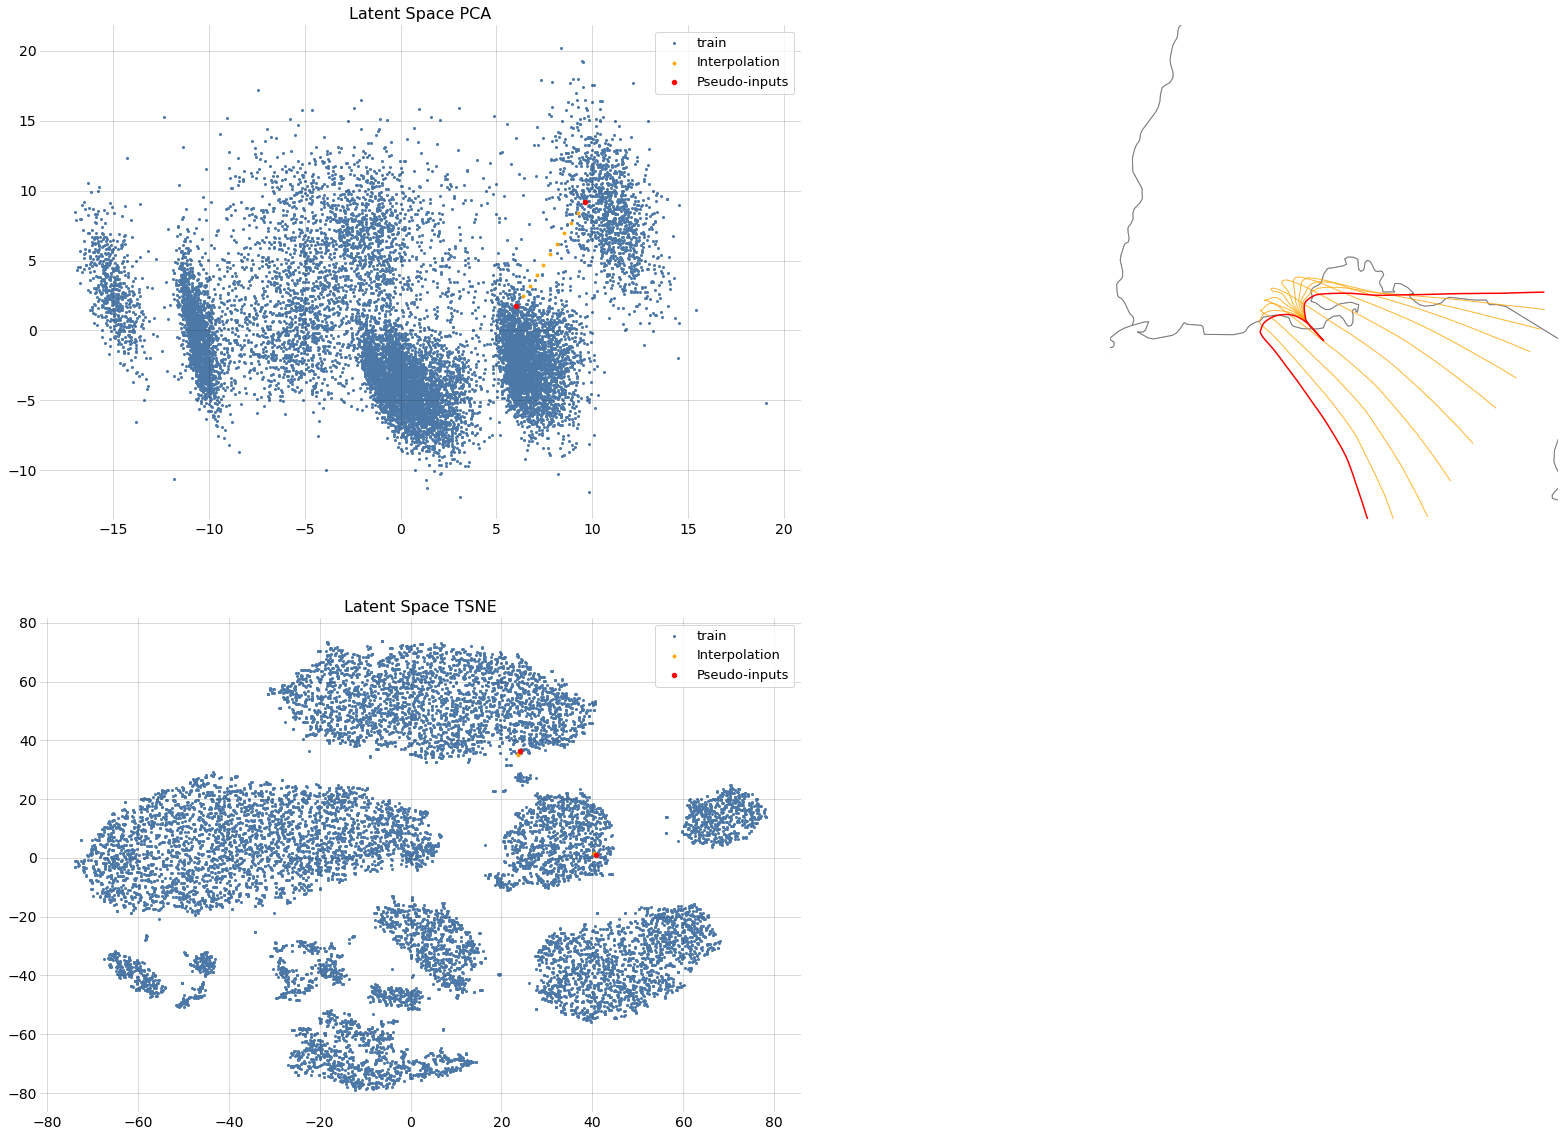

In [22]:
i = np.random.randint(int(len(pseudo_means)/2))

col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()
js = np.argsort(col)[[i,-i]]
# js = [190, 959]

n_gen = 10
inter = []

for n in range(1,n_gen):
    inter.append(((n_gen-n)/n_gen)*pseudo_means[js[0]].detach() + (n/n_gen)*pseudo_means[js[1]].detach())
inter = torch.stack(inter)

gen = torch.cat((inter, pseudo_means[js]), axis=0)
out = t.decode(gen)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

concat = np.concatenate((z_train, gen.detach().numpy()))
gen_embedded1 = TSNE(n_components=2).fit_transform(concat)

pca = PCA(n_components=2).fit(concat[:-len(gen)])
gen_embedded2 = pca.transform(concat)

print(js)

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())
    ax2 = fig.add_subplot(223)

    ax2.scatter(gen_embedded1[:-len(gen), 0], gen_embedded1[:-len(gen), 1], s=4, label = "train")
    ax2.scatter(gen_embedded1[-len(gen):, 0], gen_embedded1[-len(gen):, 1], s=8, c='orange', label = "Interpolation")
    ax2.scatter(gen_embedded1[-2:, 0], gen_embedded1[-2:, 1], s=20, c='red', label = "Pseudo-inputs")
    ax2.title.set_text("Latent Space TSNE")
    ax2.legend()

    ax0.scatter(gen_embedded2[:-len(gen), 0], gen_embedded2[:-len(gen), 1], s=4, label = "train")
    ax0.scatter(gen_embedded2[-len(gen):, 0], gen_embedded2[-len(gen):, 1], s=8, c='orange', label = "Interpolation")
    ax0.scatter(gen_embedded2[-2:, 0], gen_embedded2[-2:, 1], s=20, c='red', label = "Pseudo-inputs")
    ax0.title.set_text("Latent Space PCA")
    ax0.legend()

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    out_traf[["TRAJ_" + str(i) for i in range(n_gen-1)]].plot(ax1, color="orange")

    out_traf["TRAJ_"+str(len(out_traf)-2)].plot(ax1, color="red", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-1)].plot(ax1, color="red", lw=1.5)

[190, 959]


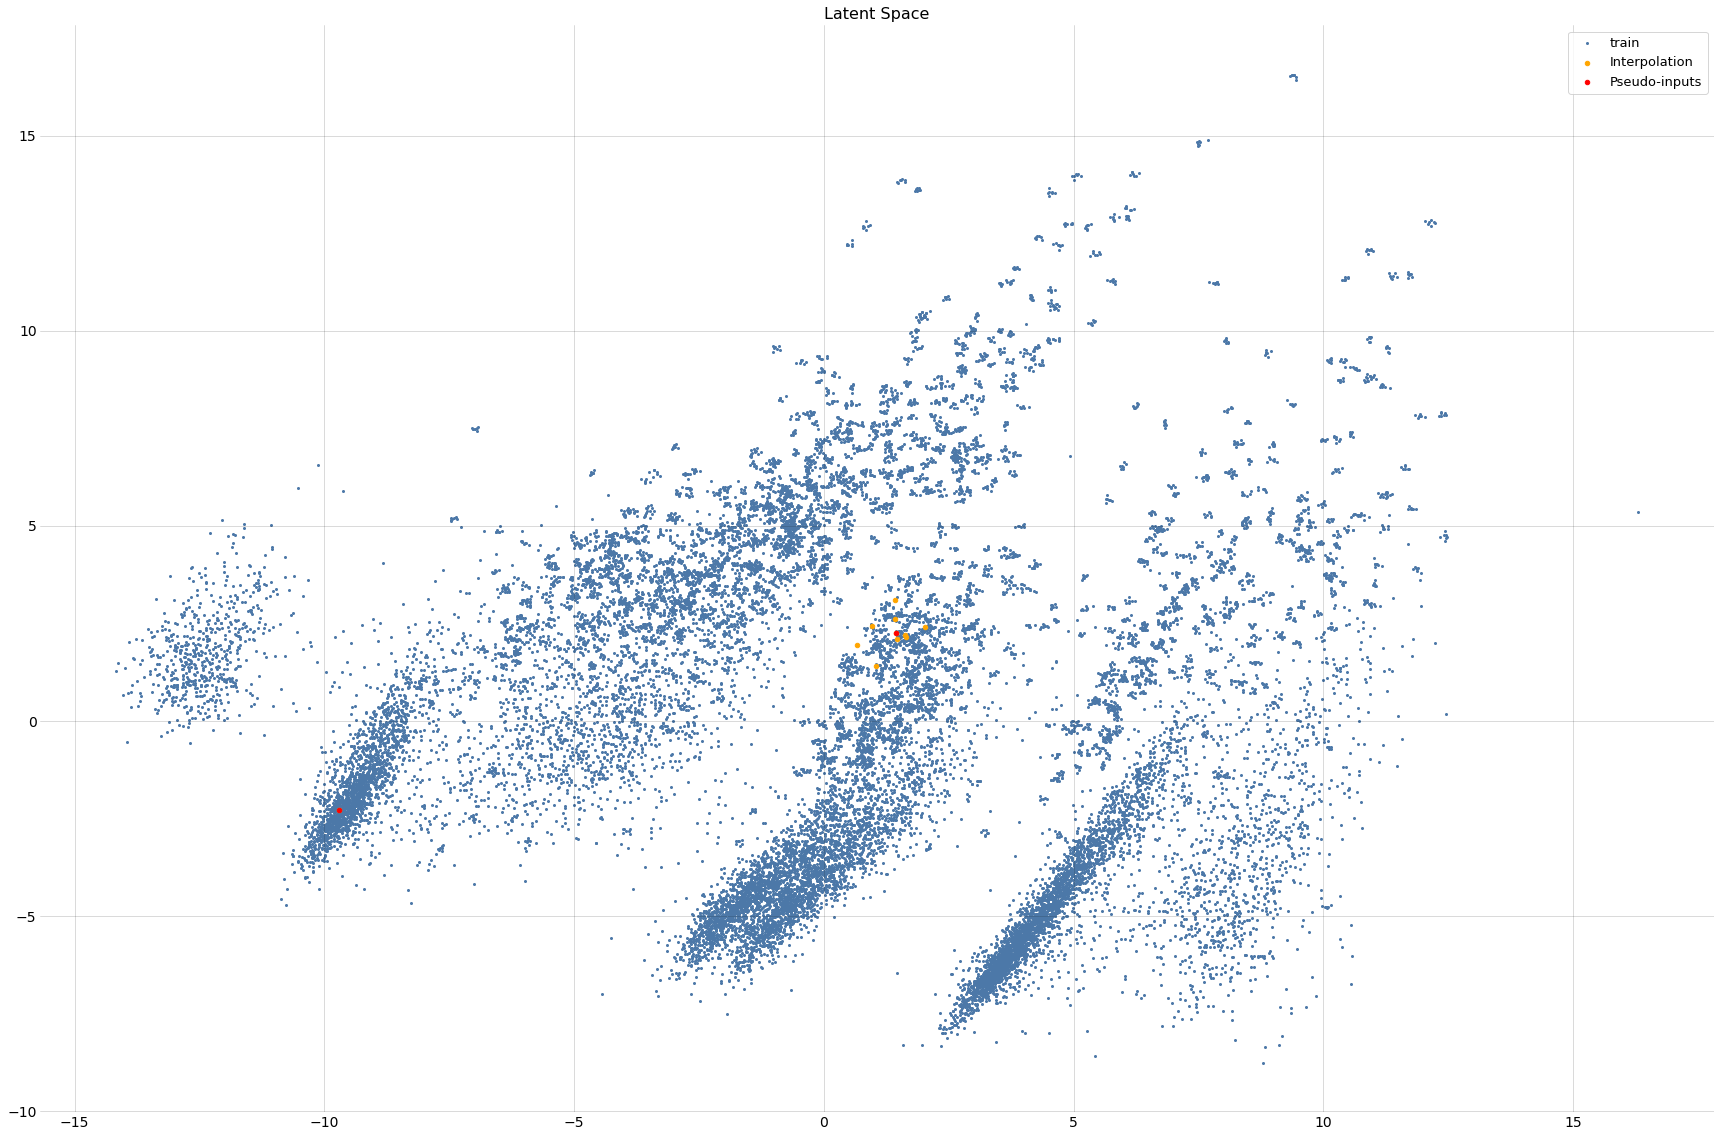

In [58]:
i = np.random.randint(int(len(pseudo_means)/2))

col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()
# js = np.argsort(col)[[i,-i]]
js = [190, 959]

n_gen = 10
inter = []

for n in range(1,n_gen):
    inter.append(((n_gen-n)/n_gen)*pseudo_means[js[0]].detach() + (n/n_gen)*pseudo_means[js[1]].detach())
inter = torch.stack(inter)

gen = torch.cat((inter, pseudo_means[js]), axis=0)
out = t.decode(gen)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

pca = PCA(n_components=2).fit(concat[:-len(gen)])
gen_embedded = pca.transform(concat)

print(js)

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(111)

    ax0.scatter(gen_embedded[:-len(gen), 0], gen_embedded[:-len(gen), 1], s=4, label = "train")
    ax0.scatter(gen_embedded[-len(gen):, 0], gen_embedded[-len(gen):, 1], s=20, c='orange', label = "Interpolation")
    ax0.scatter(gen_embedded[-2:, 0], gen_embedded[-2:, 1], s=20, c='red', label = "Pseudo-inputs")
    ax0.title.set_text("Latent Space")
    ax0.legend()

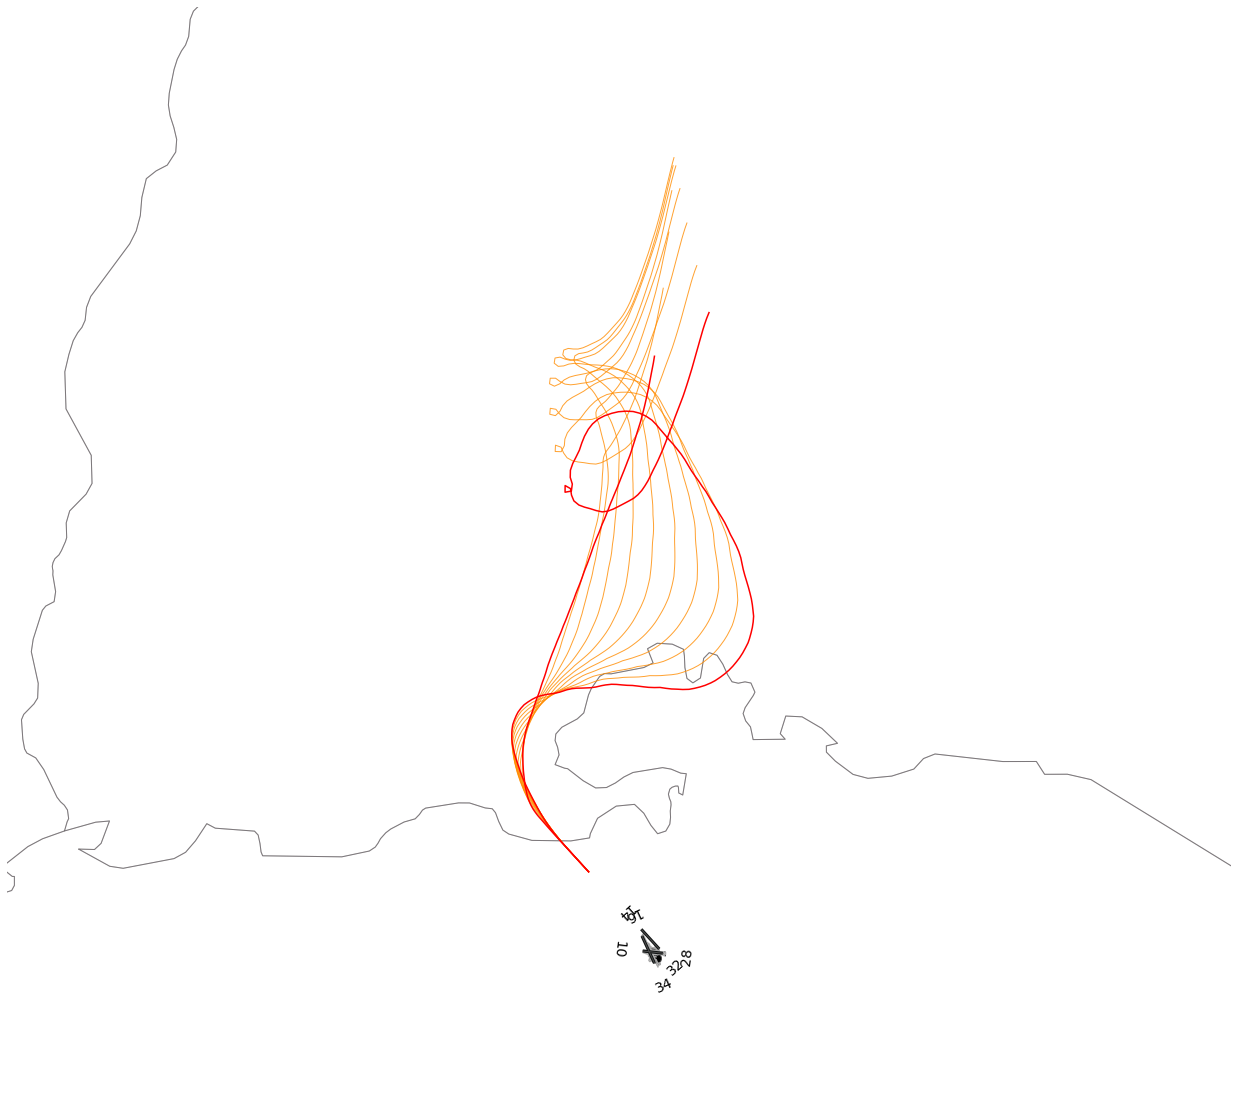

In [62]:
from traffic.data import airports

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111, projection=EuroPP())

    ax.add_feature(countries())
    ax.figure
    ax.set_extent((7.5, 9.5, 47.3, 48.5))
    out_traf[["TRAJ_" + str(i) for i in range(n_gen-1)]].plot(ax, color="darkorange")

    out_traf["TRAJ_"+str(len(out_traf)-2)].plot(ax, color="red", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-1)].plot(ax, color="red", lw=1.5)

    airports["LSZH"].plot(ax, footprint=True, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

190


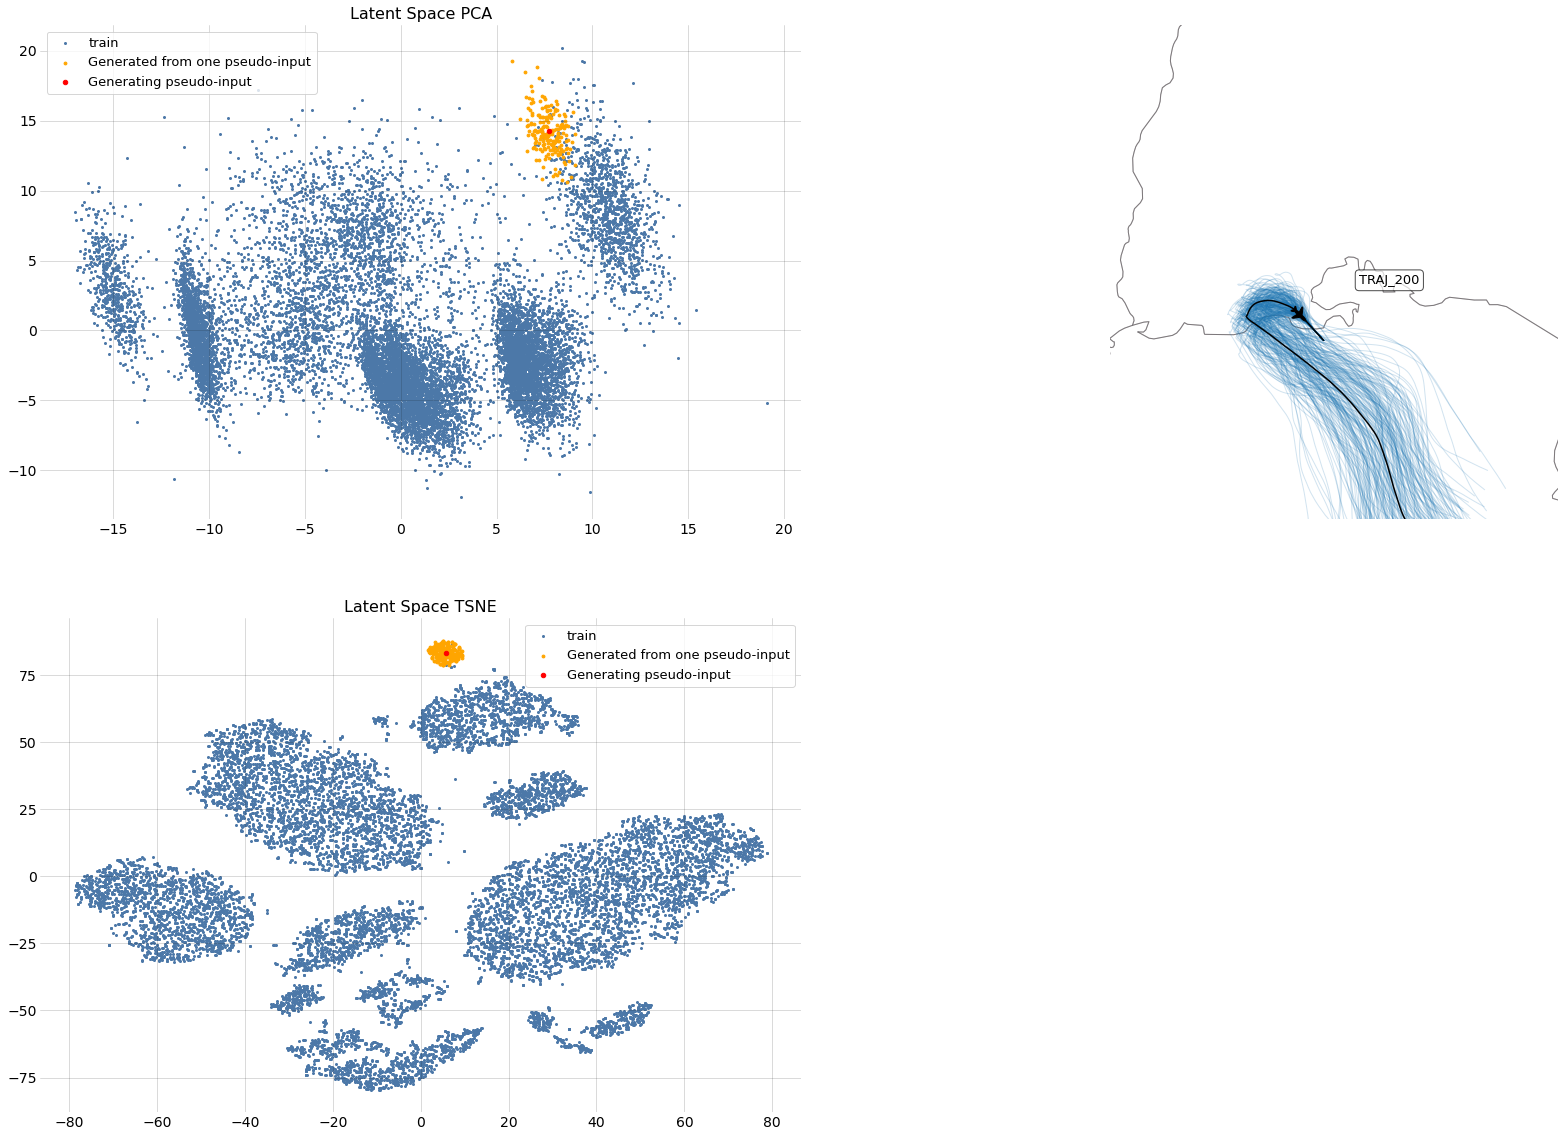

In [24]:
j = 190

dist = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[j], pseudo_scales[j]), 1)
gen = dist.sample(torch.Size([200]))
gen = torch.cat((gen, pseudo_means[j].unsqueeze(0)), axis=0)
out = t.decode(gen)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

concat = np.concatenate((z_train, gen.detach().numpy()))
gen_embedded1 = TSNE(n_components=2).fit_transform(concat)

pca = PCA(n_components=2).fit(concat[:-len(gen)])
gen_embedded2 = pca.transform(concat)

print(j)

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())
    ax2 = fig.add_subplot(223)

    ax2.scatter(gen_embedded1[:-len(gen), 0], gen_embedded1[:-len(gen), 1], s=4, label = "train")
    ax2.scatter(gen_embedded1[-len(gen):, 0], gen_embedded1[-len(gen):, 1], s=8, c='orange', label = "Generated from one pseudo-input")
    ax2.scatter(gen_embedded1[-1, 0], gen_embedded1[-1, 1], s=20, c='red', label = "Generating pseudo-input")
    ax2.title.set_text("Latent Space TSNE")
    ax2.legend()

    ax0.scatter(gen_embedded2[:-len(gen), 0], gen_embedded2[:-len(gen), 1], s=4, label = "train")
    ax0.scatter(gen_embedded2[-len(gen):, 0], gen_embedded2[-len(gen):, 1], s=8, c='orange', label = "Generated from one pseudo-input")
    ax0.scatter(gen_embedded2[-1, 0], gen_embedded2[-1, 1], s=20, c='red', label = "Generating pseudo-input")
    ax0.title.set_text("Latent Space PCA")
    ax0.legend()

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    out_traf.plot(ax1, color="#1f77b4", alpha=0.2)
    out_traf["TRAJ_"+str(len(out_traf)-1)].plot(ax1, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-1)].at_ratio(0.85).plot(
        ax1,
        color="black",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

Pour exemplar VAE : 
Il semblerait que les trajectoires mal générées sont effectivement celles en bord des clusters, ou du moins celles avec des fortes variances 

To do :
- Faire un NN spécifique pour les variances dans vamprior
- More components in vamprior/exemplar
- More dimesions (64 too low)
- Essayer de déséquilibrer la base de données en elevant les trajectoires simples
- Réessayer la régularisation des pseudo-inputs
- Essayer le hierarchical VAE

# Trying to detect the real aggregated posterior

We noticed that the decoder is also able to handle points from the test dataset. However, thos points in the latent space seem to not be issued from the aggregated posterior. One assumption is that the empirical aggregated posterior "overfit" the latent space, whereas the encoder is able to produce points from a larger density, and the decoder to handle points that are also not from the empirical aggregated posterior. As a resulta, we have to try to find this real distribution in the latent space, in which we have only partial observations, that is larger than the empirical distribution, but also denser in the right areas than the standard gaussian.

One way to try : 
- get the aggregated posterior f_N from the train in the latent space
- get the GMM g_n from the test in the latent space
- Sample X from f_N and Y from g_n

For i in range(1,N):
- Learn GMM of i components on X
- Evaluate the likelyhood of Y in this GMM

Then we keep the GMM that ouputs the larger likelyhood and assume it's the looked after distribution

In [12]:
#train 
h_train = t.VAE.encoder(dataset.data)
q_train = t.VAE.lsr(h_train)
params_train = t.VAE.lsr.dist_params(q_train)

#test 
h_test = t.VAE.encoder(test.data)
q_test = t.VAE.lsr(h_test)
params_test = t.VAE.lsr.dist_params(q_test)

In [13]:
#Ce n'est pas la méthode la plus adaptée : On risque de ne pas tirer certaines composantes, et donc d'avoir un échantillon non représentatif de la totalité de la GMM
#Ici on a une mixture gaussienne de 14000 composantes, ie la posterior aggrégée dans l'espace latent


# mix_train = torch.distributions.Categorical(torch.ones(len(dataset.data),))
# comp_train = torch.distributions.Independent(torch.distributions.Normal(params_train[1][:,0,:], params_train[2][:,0,:]), 1)
# gmm_train = torch.distributions.mixture_same_family.MixtureSameFamily(mix_train, comp_train)

# mix_test = torch.distributions.Categorical(torch.ones(len(test.data),))
# comp_test = torch.distributions.Independent(torch.distributions.Normal(params_test[1][:,0,:], params_test[2][:,0,:]), 1)
# gmm_test = torch.distributions.mixture_same_family.MixtureSameFamily(mix_test, comp_test)

# gmm_train_points = gmm_train.sample(sample_shape=torch.Size([10000])).numpy()
# gmm_test_points = gmm_test.sample(sample_shape=torch.Size([10000])).numpy()

In [14]:
#Here we have the collection of every posterior distribution
#14000 different gaussian mixtures
#When we sample in it, we sample one point per gaussian mixture
#That way, we have points within every component of the empirical aggregated posterior

n_sample = 3 #nb sample per posterior
latent_shape = t.VAE.lsr.out_dim

gmm_train_points = q_train.sample(torch.Size([n_sample])).view(n_sample*len(dataset.data), latent_shape).numpy()
gmm_test_points = q_test.sample(torch.Size([n_sample])).view(n_sample*len(test.data), latent_shape).numpy()

In [18]:
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm

L_train=[]
L_test=[]
#from 1500, the test likelyhood deacreases
n_components = np.arange(0,1000,10)
n_components[0] = 1

for i in tqdm(n_components) : 
    fitted_gm = GaussianMixture(n_components = i, covariance_type="diag", reg_covar=5*1e-5, random_state=0).fit(gmm_train_points)
    L_train.append(fitted_gm.score(gmm_train_points))
    L_test.append(fitted_gm.score(gmm_test_points))

  0%|          | 0/100 [00:00<?, ?it/s]

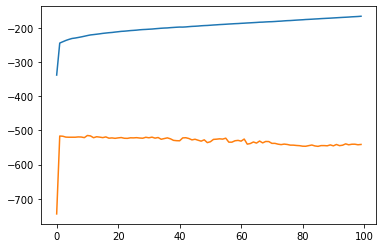

In [19]:
plt.plot(L_train)
plt.plot(L_test)

In [23]:
#The highest likelyhood seems to be achieved for 100 components
n_components[np.argmax(L_test)]

100

In [24]:
#Fit gaussian mixture with 10 components on train data :
fitted_gm = GaussianMixture(n_components = n_components[np.argmax(L_test)], covariance_type="diag", reg_covar=5*1e-5, random_state=0).fit(gmm_train_points)

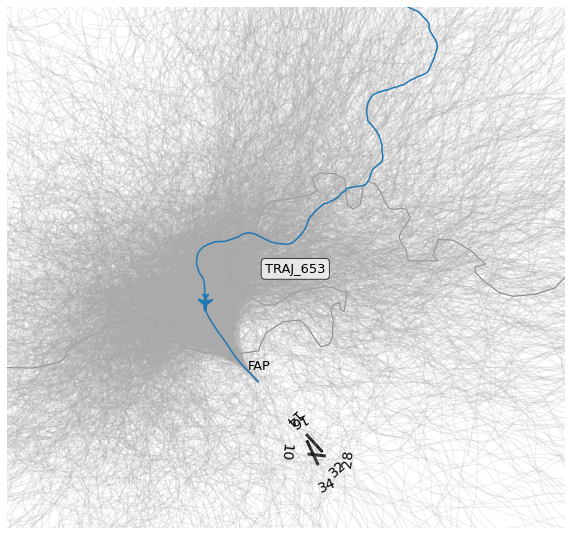

In [25]:
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from traffic.data import navaids
from traffic.data import airports

#Can samples from this distributionbe decoded ?

new_z = fitted_gm.sample(2000)[0]

out = t.decode(torch.tensor(new_z, dtype = torch.float))
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    out_traf.plot(ax, alpha=0.2)

    k =  np.random.randint(len(out_traf))
    out_traf[k].plot(ax, color="#1f77b4", lw=1.5)
    out_traf[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )